# Airbnb Pricing Model

In [162]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

print(tf.__version__)

2.1.0


## Dataset de entrada

In [2]:
listings=pd.read_csv('listings.csv')
print('El dataset de entrada contiene', len(listings.columns), 'columnas', 'y', len(listings), 'filas')

El dataset de entrada contiene 92 columnas y 3818 filas


## Limpieza de los datos

In [3]:
for col in listings.columns: ##Eliminando las columnas que tienen un solo valor 
    if len(listings[col].unique()) == 1:
        listings.drop(col,inplace=True,axis=1)
        
print('Luego de remover las columnas con un valor único permanecen', len(listings.columns),'columnas')

Luego de remover las columnas con un valor único permanecen 81 columnas


In [4]:
def convert_to_numbers(dataset, column): #Eliminando $ del string y convirtiendolo en número
    dataset[column]=dataset[column].str.replace('[$,]', '').astype('float')
    return print('La columna', column, 'ha sido modificada')

Columns_to_convert=['price', 'cleaning_fee', 'extra_people', 'security_deposit']

for variable in Columns_to_convert:
    convert_to_numbers(listings, variable)


La columna price ha sido modificada
La columna cleaning_fee ha sido modificada
La columna extra_people ha sido modificada
La columna security_deposit ha sido modificada


In [5]:
def removing_percentage (dataset, column): #Eliminando % del string y convirtiendolo en número
    dataset[column]=dataset[column].str.replace('%', '').astype('float')
    print('La columna', column, 'ha sido modificada')

removing_perc=['host_acceptance_rate', 'host_response_rate']

for var in removing_perc:
    removing_percentage(listings, var)

La columna host_acceptance_rate ha sido modificada
La columna host_response_rate ha sido modificada


In [6]:
listings.cleaning_fee=listings.cleaning_fee.fillna(0) #Asumiendo que los vacios de estos campos corresponden a 0
listings.security_deposit=listings.security_deposit.fillna(0)

Se identifican y remueven las columnas que contienen un porcentaje superior de 30% de datos faltantes

In [7]:
most_missing_cols = set(listings.columns[listings.isnull().mean() > 0.30])
most_missing_cols #Columnas con un porcentaje de datos faltantes superior al 30%

{'monthly_price', 'notes', 'square_feet', 'weekly_price'}

Identificando y removiendo columnas de: urls, pricing (diferentes al target),  texto, geogràficas diferentes al vecindario y a lat-lng, diponibilidad superior a 30 dias y relacionadas con el host.

In [8]:
url_field=list(listings.filter(like='url').columns) 
other_pricing_field=list(listings.filter(like='_price').columns)
text_field=['notes','neighborhood_overview', 'host_about','transit', 'space','summary','description']
other_geo=[ 'zipcode', 'neighbourhood', 'host_name','smart_location',  'is_location_exact', 'street', 'neighbourhood_cleansed', 'city', 'state']
availability=['availability_60', 'availability_90', 'availability_365']
host=['host_verifications', 'host_total_listings_count' ,'host_has_profile_pic', 'host_location', 'host_id','host_neighbourhood','host_location', 'calculated_host_listings_count', 'host_listings_count']

In [9]:
listings=listings.drop(url_field+other_pricing_field+text_field+other_geo+availability+host+['square_feet','first_review', 'last_review'], axis=1) #Se remueven las columnas

Se adiciona el indice de polaridad de los reviews calculado con TextBlob

In [10]:
polarity=pd.read_csv('reviews_polarity.csv')
listings=listings.merge(polarity, left_on='id', right_on='listing_id', how='left') #Adicionando el indice de polaridad calculado para los reviews
listings.columns

Index(['id', 'name', 'host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'availability_30',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'reviews_per_month', 'listing_id', 'comments_polarity'],
      dtype='object')

In [11]:
listings=listings.drop(['listing_id', 'name'], axis=1)

### Eliminando los datos faltantes

In [12]:
listings=listings.dropna()

### Variables categoricas en Dummies

In [13]:
listings.columns

Index(['id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'availability_30',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'reviews_per_month', 'comments_polarity'],
      dtype='object')

In [14]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(listings)

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,comments_polarity
0,241032,2011-08-11,within a few hours,96.0,100.0,f,t,Queen Anne,47.636289,-122.371025,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,0.0,2,5.0,1,365,4 weeks ago,14,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,4.07,0.377606
1,953595,2013-02-21,within an hour,98.0,100.0,t,t,Queen Anne,47.639123,-122.365666,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,90,today,13,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,1.48,0.399665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,2015-04-13,within a few hours,99.0,100.0,f,t,Other neighborhoods,47.664295,-122.359170,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",359.0,0.0,230.0,1,0.0,3,1125,today,18,1,80.0,8.0,10.0,4.0,8.0,10.0,8.0,f,strict,f,f,0.30,0.000000
3814,8902327,2015-10-14,within an hour,100.0,100.0,f,t,Capitol Hill,47.649552,-122.318309,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",79.0,500.0,50.0,3,25.0,2,29,2 days ago,6,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate,f,f,2.00,0.391804


In [15]:
var_categorical=['host_response_time','host_identity_verified',  'host_is_superhost', 'cancellation_policy']

In [16]:
listings=pd.concat([listings, pd.get_dummies(listings['host_response_time'])], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['host_identity_verified'], prefix='identity_verified')], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['host_is_superhost'], prefix='superhost')], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['cancellation_policy'], prefix='cancellation')], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['require_guest_profile_picture'], prefix='guest_pro_pic')], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['instant_bookable'], prefix='inst_book')], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['require_guest_phone_verification'], prefix='guest_phone_ver')], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['property_type'])], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['room_type'])], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['neighbourhood_group_cleansed'])], axis=1) 
listings=pd.concat([listings, pd.get_dummies(listings['bed_type'])], axis=1) 
#listings=pd.concat([listings, pd.get_dummies(listings['calendar_updated'])], axis=1) 

In [17]:
var_categorical=['host_response_time','host_identity_verified',  'host_is_superhost', 'cancellation_policy', 'neighbourhood_group_cleansed','bed_type', 
                 'require_guest_profile_picture', 'instant_bookable', 'require_guest_phone_verification', 'property_type', 'room_type',  'calendar_updated' ]
listings=listings.drop(var_categorical, axis=1)


In [18]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(listings)

,id,host_since,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,comments_polarity,a few days or more,within a day,within a few hours,within an hour,identity_verified_f,identity_verified_t,superhost_f,superhost_t,cancellation_flexible,cancellation_moderate,cancellation_strict,guest_pro_pic_f,guest_pro_pic_t,inst_book_f,inst_book_t,guest_phone_ver_f,guest_phone_ver_t,Apartment,Bed & Breakfast,Boat,Bungalow,Cabin,Camper/RV,Chalet,Condominium,Dorm,House,Loft,Other,Tent,Townhouse,Treehouse,Yurt,Entire home/apt,Private room,Shared room,Ballard,Beacon Hill,Capitol Hill,Cascade,Central Area,Delridge,Downtown,Interbay,Lake City,Magnolia,Northgate,Other neighborhoods,Queen Anne,Rainier Valley,Seward Park,University District,West Seattle,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
0,241032,2011-08-11,96.0,100.0,47.636289,-122.371025,4,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,0.0,2,5.0,1,365,14,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,4.07,0.377606,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,953595,2013-02-21,98.0,100.0,47.639123,-122.365666,4,1.0,1.0,1.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,90,13,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1.48,0.399665,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,2015-04-13,99.0,100.0,47.664295,-122.359170,6,2.0,3.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",359.0,0.0,230.0,1,0.0,3,1125,18,1,80.0,8.0,10.0,4.0,8.0,10.0,8.0,0.30,0.000000,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3814,8902327,2015-10-14,100.0,100.0,47.649552,-122.318309,4,1.0,1.0,2.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",79.0,500.0,50.0,3,25.0,2,29,6,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,2.00,0.391804,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [19]:
listings=listings.drop(['id', 'host_since', 'amenities', 'Chalet'], axis=1) ### Estas las voy a eliminar por ahora pero tengo pendiente convertir amenities en dummies

In [20]:
listings.columns

Index(['host_response_rate', 'host_acceptance_rate', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'comments_polarity',
       'a few days or more', 'within a day', 'within a few hours',
       'within an hour', 'identity_verified_f', 'identity_verified_t',
       'superhost_f', 'superhost_t', 'cancellation_flexible',
       'cancellation_moderate', 'cancellation_strict', 'guest_pro_pic_f',
       'guest_pro_pic_t', 'inst_book_f', 'inst_book_t', 'guest_phone_ver_f',
       'guest_phone_ver_t', 'Apartment', 'Bed & Breakfast', 'Boat', 'Bungalow',
       'Cab

## Datos de salida

In [21]:
dataset=listings
print('Las dimensiones del conjunto de salida son', dataset.shape)

Las dimensiones del conjunto de salida son (2655, 83)


## Dividiendo los datos en entrenamiento y testing

In [22]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [23]:
train_dataset.head()

,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,...,Queen Anne,Rainier Valley,Seward Park,University District,West Seattle,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
1011,90.0,100.0,47.593623,-122.307462,2,1.0,0.0,1.0,90.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3532,100.0,100.0,47.618496,-122.309342,2,5.0,1.0,1.0,125.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3786,97.0,100.0,47.661396,-122.352256,1,1.5,1.0,1.0,87.0,250.0,...,0,0,0,0,0,0,0,0,0,1
2737,100.0,100.0,47.635884,-122.321857,4,1.0,1.0,3.0,100.0,200.0,...,0,0,0,0,0,0,0,0,0,1
2015,100.0,100.0,47.691774,-122.365675,2,1.0,1.0,1.0,50.0,0.0,...,0,0,0,0,0,0,0,0,0,1


## Descriptivo

In [24]:
train_stats = train_dataset.describe()
train_stats.pop("price")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
host_response_rate,2124.0,95.471281,10.577958,17.000000,98.000000,100.000000,100.000000,100.000000
host_acceptance_rate,2124.0,99.952919,2.169815,0.000000,100.000000,100.000000,100.000000,100.000000
latitude,2124.0,47.628310,0.042236,47.507284,47.608229,47.623134,47.662396,47.733358
longitude,2124.0,-122.333003,0.031471,-122.417219,-122.353539,-122.330097,-122.310337,-122.254189
accommodates,2124.0,3.369115,1.985654,1.000000,2.000000,3.000000,4.000000,16.000000
...,...,...,...,...,...,...,...,...
Airbed,2124.0,0.005650,0.074970,0.000000,0.000000,0.000000,0.000000,1.000000
Couch,2124.0,0.002825,0.053087,0.000000,0.000000,0.000000,0.000000,1.000000
Futon,2124.0,0.018362,0.134287,0.000000,0.000000,0.000000,0.000000,1.000000
Pull-out Sofa,2124.0,0.014595,0.119954,0.000000,0.000000,0.000000,0.000000,1.000000


## Separando caracteristicas y etiquetas

In [25]:
train_labels = train_dataset.pop('price')
test_labels = test_dataset.pop('price')

## Normalizando

In [26]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [27]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(normed_train_data)

,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,comments_polarity,a few days or more,within a day,within a few hours,within an hour,identity_verified_f,identity_verified_t,superhost_f,superhost_t,cancellation_flexible,cancellation_moderate,cancellation_strict,guest_pro_pic_f,guest_pro_pic_t,inst_book_f,inst_book_t,guest_phone_ver_f,guest_phone_ver_t,Apartment,Bed & Breakfast,Boat,Bungalow,Cabin,Camper/RV,Condominium,Dorm,House,Loft,Other,Tent,Townhouse,Treehouse,Yurt,Entire home/apt,Private room,Shared room,Ballard,Beacon Hill,Capitol Hill,Cascade,Central Area,Delridge,Downtown,Interbay,Lake City,Magnolia,Northgate,Other neighborhoods,Queen Anne,Rainier Valley,Seward Park,University District,West Seattle,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
1011,-0.517234,0.021698,-0.821268,0.811557,-0.689503,-0.428754,-1.486032,-0.635381,-0.672775,-0.638587,-0.544665,-0.645160,-0.067110,0.773089,-1.476172,-0.343030,-1.779522,-0.934055,0.559447,0.344584,-1.374984,-0.987926,-0.632312,1.011216,-1.870031,-0.089803,-0.410168,1.578685,-1.131731,2.216781,-2.216781,0.592435,-0.592435,1.813659,-0.740167,-0.838425,0.338115,-0.338115,0.486754,-0.486754,0.369286,-0.369286,1.106123,-0.097474,-0.021698,-0.061473,-0.092428,-0.061473,-0.158382,-0.021698,-0.910531,-0.106879,-0.081437,-0.021698,-0.166022,-0.021698,-0.021698,0.706940,-0.654353,-0.185923,-0.27162,-0.188615,-0.402305,-0.133118,3.067138,-0.138509,-0.425708,-0.048564,-0.106879,-0.123649,-0.141998,-0.512502,-0.28148,-0.218704,-0.117626,-0.187273,-0.225701,-0.07536,-0.053212,-0.136734,-0.121673,0.20785
3532,0.428128,0.021698,-0.232359,0.751819,-0.689503,6.516333,-0.320904,-0.635381,-0.672775,-0.944473,-0.544665,-0.645160,-0.021114,-1.373375,1.093020,-0.343030,-0.238986,-0.934055,0.559447,-1.260451,-1.374984,0.624952,-0.632312,-0.699390,0.694329,-0.089803,-0.410168,-0.633140,0.883186,-0.450892,0.450892,0.592435,-0.592435,-0.551112,1.350411,-0.838425,0.338115,-0.338115,0.486754,-0.486754,0.369286,-0.369286,-0.903633,-0.097474,-0.021698,-0.061473,-0.092428,-0.061473,-0.158382,-0.021698,1.097743,-0.106879,-0.081437,-0.021698,-0.166022,-0.021698,-0.021698,-1.413881,1.527508,-0.185923,-0.27162,-0.188615,2.484506,-0.133118,-0.325883,-0.138509,-0.425708,-0.048564,-0.106879,-0.123649,-0.141998,-0.512502,-0.28148,-0.218704,-0.117626,-0.187273,-0.225701,-0.07536,-0.053212,-0.136734,-0.121673,0.20785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3693,0.428128,0.021698,0.495416,-0.414901,-0.689503,-0.428754,-0.320904,-0.635381,0.809645,-0.557018,-0.544665,0.966236,-0.067110,0.773089,0.827242,-0.593355,-1.009254,-2.399293,-2.037853,-1.260451,0.331893,0.624952,-1.994411,-0.387393,-2.007446,-0.089803,-0.410168,-0.633140,0.883186,2.216781,-2.216781,0.592435,-0.592435,-0.551112,-0.740167,1.192151,-2.956180,2.956180,0.486754,-0.486754,-2.706651,2.706651,1.106123,-0.097474,-0.021698,-0.061473,-0.092428,-0.061473,-0.158382,-0.021698,-0.910531,-0.106879,-0.081437,-0.021698,-0.166022,-0.021698,-0.021698,-1.413881,1.527508,-0.185923,-0.27162,-0.188615,-0.402305,-0.133118,-0.325883,-0.138509,-0.425708,-0.048564,-0.106879,-0.123649,-0.141998,1.950292,-0.28148,-0.218704,-0.117626,-0.187273,-0.225701,-0.07536,-0.053212,-0.136734,-0.121673,0.20785
1073,0.428128,0.021698,-0.487406,-0.237458,2.332171,11.725148,-0.320904,5.328535,-0.672775,-0.944473,-0.544665,1.944584,-0.067110,0.773089,-1.564765,-0.

# El modelo

### Construye el modelo

In [173]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer=Adam(0.1)#Revisar, ensayar Adam

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [174]:
model = build_model()

In [175]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 64)                5312      
_________________________________________________________________
dense_136 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 33        
Total params: 7,425
Trainable params: 7,425
Non-trainable params: 0
_________________________________________________________________


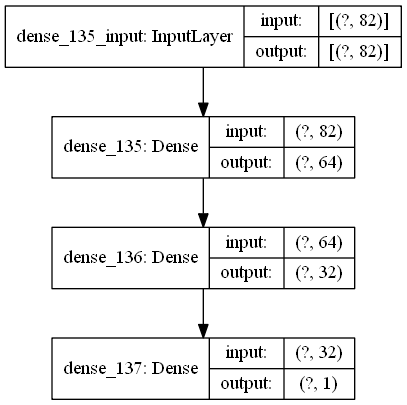

In [176]:
plot_model(model, to_file='regresion_model_keras.png', show_shapes=True)

In [177]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.1847874 ],
       [-0.47148094],
       [-1.1282572 ],
       [-0.56983954],
       [-0.66682327],
       [ 0.00143683],
       [ 0.35320842],
       [-1.1170576 ],
       [ 0.5757731 ],
       [ 0.5654565 ]], dtype=float32)

### Entrenamiento del modelo

In [178]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [179]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,6857.317235,54.927574,6857.317383,8227.847463,55.406872,8227.847656,495
496,6854.629425,55.145550,6854.629883,8232.031571,55.567104,8232.032227,496
497,6855.644648,55.236031,6855.644531,8235.379577,55.684410,8235.379883,497
498,6854.364253,55.194973,6854.363281,8230.623110,55.514999,8230.623047,498
499,6855.883274,54.974297,6855.884766,8226.746880,55.362133,8226.746094,499


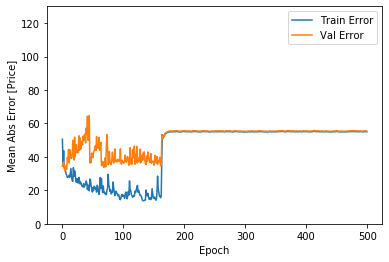

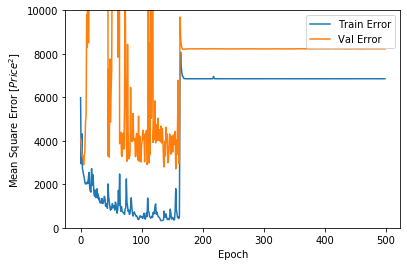

In [180]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Price]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,130])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Price^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,10000])
  plt.legend()
  plt.show()


plot_history(history)


...............

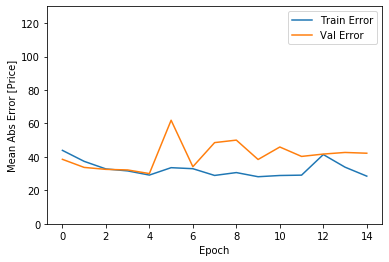

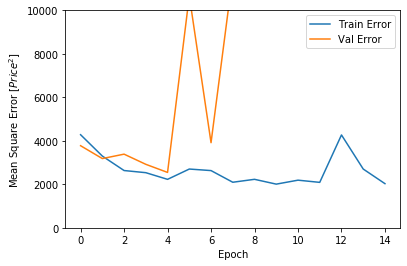

In [181]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [182]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

531/531 - 0s - loss: 6112.7854 - mae: 34.6512 - mse: 6112.7847
Testing set Mean Abs Error: 34.65
